<a href="https://colab.research.google.com/github/inoueshinji8/PythonStudy/blob/main/quantum_chemical_metropolis_hastings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://tsujimotter.hatenablog.com/entry/metropolis-hastings-algorithm
を参考に

全体の存在確率のうち大きい方から9割の部分までを電子の存在部分とする<br>
という手法などが紹介されていたが、その中で

棄却サンプリング法というのが紹介された<br>
>棄却サンプリング法は、f(x,y,z) とは直接関係ない（たとえば一様乱数のような）確率分布 g(x,y,z) にしたがう乱数から、f と g の確率密度関数としての差を考慮しつつ、適切な確率で乱数を「棄却」することによって、目的の f(x,y,z) にしたがう乱数を得る手法です。

だがこの方法は時間がかかる<br>

メトロポリス・ヘイスティングス法というので解決する<br>
マルコフ連鎖モンテカルロ法（MCMC）という一般的な枠組みの一手法だとの事

3次元ベクトル x=(x,y,z) および u=(u,v,w) を変数に持つ、条件付き確率密度関数 Q(x∣u) を用意する。この Q を提案分布といいます。

Qは多次元正規分布を用いる、が、

この時に対称的な式なのでうまく相殺され、最終的には確率密度関数の比だけ分かればいい(確率密度関数の規格化定数すら要らない)ので計算し易い

In [1]:
# メトロポリス・ヘイスティング法による電子分布の可視化

import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d

import math

In [2]:
# 動径波動関数（ボーア半径を a_0 = 1 に正規化）
def radial_wave_function(r, n, l, Z_eff):
    rho = 2.0 * Z_eff * r / n
    if n == 1 and l == 0:
        return (Z_eff ** 1.5) * np.exp(-rho/2.0) * 2.0
    elif n == 2 and l == 0:
        return (Z_eff ** 1.5) * np.exp(-rho/2.0) * (2.0 - rho) / (2.0*np.sqrt(2.0))
    elif n == 2 and l == 1:
        return (Z_eff ** 1.5) * np.exp(-rho/2.0) * rho / (2.0*np.sqrt(6.0))
    elif n == 3 and l == 0:
        return (Z_eff ** 1.5) * np.exp(-rho/2.0) * (6.0 - 6.0*rho + rho**2) / (9.0*np.sqrt(3.0))
    elif n == 3 and l == 1:
        return (Z_eff ** 1.5) * np.exp(-rho/2.0) * (4.0 - rho) * rho / (9.0*np.sqrt(6.0))
    elif n == 3 and l == 2:
        return (Z_eff ** 1.5) * np.exp(-rho/2.0) * (rho**2) / (9.0*np.sqrt(30.0))

In [3]:
# 球面調和関数（ただし、実関数表示したもの）
def spherical_harmonics(theta, phi, l, m):
    if l == 0:
        if m == 0:
            # l=0, m=0
            return np.sqrt(1.0/(4*np.pi))
    if l == 1:
        if m == 0:
            # l=1, m=0
            return np.sqrt(3.0/(4.0*np.pi)) * np.cos(theta)
        if m == 1:
            # l=1, m=+1
            return np.sqrt(3.0/(4.0*np.pi)) * np.sin(theta) * np.cos(phi)
        if m == -1:
            # l=1, m=+1
            return np.sqrt(3.0/(4.0*np.pi)) * np.sin(theta) * np.sin(phi)
    if l == 2:
        if m == 0:
            return np.sqrt(5.0/(16.0*np.pi)) * (3.0*(np.cos(theta)**2) - 1.0)
        if m == 1:
            return np.sqrt(15.0/(4.0*np.pi)) * np.cos(theta) * np.sin(theta) * np.cos(phi)
        if m == -1:
            return np.sqrt(15.0/(4.0*np.pi)) * np.cos(theta) * np.sin(theta) * np.sin(phi)
        if m == 2:
            return np.sqrt(15.0/(16.0*np.pi)) * (np.sin(theta)**2) * np.cos(2*phi)
        if m == -2:
            return np.sqrt(15.0/(16.0*np.pi)) * (np.sin(theta)**2) * np.sin(2*phi)


In [4]:
# 水素様原子の波動関数 Ψ_{n,l,m}(x, y, z)
#
# (n,l,m): 量子数
# Z_eff:   有効核電荷
# 
def f(x, y, z, n, l, m, Z_eff):
    # 座標系を (x,y,z) -> (r,θ,φ) に変換
    r = np.sqrt(x*x + y*y + z*z)
    
    theta = 0.0
    phi = 0.0
    if r > 0:
        theta = np.arccos( z / r )
    if y == 0:
        if x < 0:
            phi = np.pi
    elif x*x+y*y > 0:
        phi = np.sign(y) * np.arccos(x/np.sqrt(x*x+y*y))
        
    # 動径波動関数と球面調和関数の積を計算して出力
    return (radial_wave_function(r, n, l, Z_eff) * spherical_harmonics(theta, phi, l, m))

In [5]:
# 量子数
n = 3
l = 2
m = 0

# 有効核電荷
Z = 1        # 水素原子を想定しているので Z = 1
Z_eff = Z


# サンプリング数の設定
N = 5000                  # サンプリング目標個数
x_range = 18              # 座標の範囲 (-x_range, x_range)


# メトロポリス・ヘイスティング法を使った電子雲のサンプリング
num_of_points = 0  # 採択されたデータ数

x = 1
y = 1
z = 1


# 波動関数が正のデータを格納する変数
x1_list = []
y1_list = []
z1_list = []

# 波動関数が負のデータを格納する変数
x2_list = []
y2_list = []
z2_list = []

In [6]:
while num_of_points < N:
    if num_of_points % 10 == 0:
        print(num_of_points)
    # 確率分布 Q(x*|x_t) から次の状態の候補 x* の乱数生成（今回は Q として3次元ガウス分布を選択）
    values = np.random.multivariate_normal([x, y, z], [[10,0,0],[0,10,0],[0,0,10]], 1)  # 乱数生成
    x_star = values[0,0]
    y_star = values[0,1]
    z_star = values[0,2]

    f_t = f(x, y, z, n, l, m, Z_eff)                    # xの波動関数
    f_star = f(x_star, y_star, z_star, n, l, m, Z_eff)  # x* の波動関数

    # 採択率を計算  α = p(x*) / p(x_t)
    alpha = (f_star ** 2) / (f_t ** 2)

    # 採択率により決定
    r = np.random.rand(1)[0]   # 0 <= r <= 1 の一様乱数 r を生成
    if r <= alpha:
        x = x_star
        y = y_star
        z = z_star
        if f_star > 0:
            x1_list.append(x)
            y1_list.append(y)
            z1_list.append(z)
        else:
            x2_list.append(x)
            y2_list.append(y)
            z2_list.append(z)            
        num_of_points += 1

0
10
20
20
20
30
40
40
50
60
60
70
80
90
100
110
110
120
120
130
140
150
160
170
180
180
190
190
200
200
200
210
210
220
230
240
240
240
250
260
260
270
270
280
280
280
290
290
300
310
310
310
310
310
310
310
310
310
320
320
320
320
330
330
330
340
350
360
370
380
380
390
390
390
400
400
410
410
410
410
410
420
420
430
440
450
450
450
450
460
460
460
470
480
480
480
480
480
490
490
490
490
500
500
500
500
500
500
500
510
520
530
530
530
530
530
540
550
560
560
560
570
580
580
590
600
610
620
620
620
620
620
620
620
620
620
620
630
640
650
660
670
670
680
690
690
700
710
720
720
720
720
720
730
740
740
750
760
770
780
790
800
800
810
810
820
830
840
840
850
850
860
870
870
880
880
890
900
900
910
920
930
930
930
930
930
940
940
940
940
940
950
950
950
950
960
960
960
960
960
970
970
970
970
970
970
980
990
990
990
1000
1010
1010
1020
1030
1040
1040
1040
1040
1040
1040
1050
1050
1060
1070
1080
1090
1100
1100
1100
1100
1110
1120
1130
1140
1140
1140
1140
1150
1160
1160
1170
1180
1190
1190


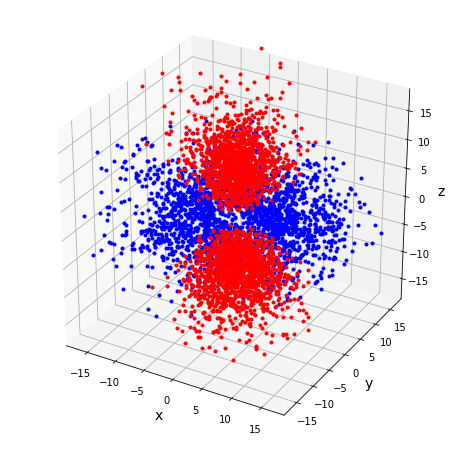

In [7]:
# figureを生成する
X1 = np.array(x1_list)
Y1 = np.array(y1_list)
Z1 = np.array(z1_list)

X2 = np.array(x2_list)
Y2 = np.array(y2_list)
Z2 = np.array(z2_list)

# matplotlibによる可視化
fig = plt.figure(figsize=(8.0, 8.0))
ax = fig.add_subplot(1,1,1, projection='3d')

ax.set_xlim3d(-x_range, x_range)
ax.set_ylim3d(-x_range, x_range)
ax.set_zlim3d(-x_range, x_range)

# 軸の設定
ax.set_xlabel("x", size = 14)
ax.set_ylabel("y", size = 14)
ax.set_zlabel("z", size = 14)

ax.plot(X2,Y2,Z2,color='b',marker=".",linestyle='None')
ax.plot(X1,Y1,Z1,color='r',marker=".",linestyle='None')

plt.show()

量子数を

n=3<br>
l=2<br>
m=0

以外も入れて、試してみよう